In [1]:
from ROOT import TFile,TTree,TH1F,gStyle,TLatex,TCanvas,TGraphErrors,TLegend,TH2F,TLine,TGraph,gPad,TGraph2D
from scipy import integrate
import pandas as pd
import numpy as np
from scipy.interpolate import LinearNDInterpolator
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

Welcome to JupyROOT 6.24/02


In [2]:
events=50000000
beamE=8.8
days=50
eventtxt="1M Monte Carlo Photoproduction"

In [3]:
inFile=TFile("data/paper_ed_beamE_8.80_evts_50000000_process_photo_coherent_detector_SoLID_model_PomeronLQCD.root","READ")
tree=inFile.Get("tree")
c=TCanvas("c","c",800,600)

In [4]:
lumi = 1.2e37 * 0.5 * 1.0e-24 * 1.0e-9 * 3600.0 * 24 * days
print("Luminosity =", lumi/3600.0/24/50,"(events/nb/s)")
print("Integrated Luminosity =",lumi,"(events/nb)")

Luminosity = 5999.999999999999 (events/nb/s)
Integrated Luminosity = 25919999999.999992 (events/nb)


In [5]:
gStyle.SetOptStat(0)
gStyle.SetHistLineWidth(2)
gStyle.SetTitleXSize(0.045)
gStyle.SetTitleYSize(0.045)
gStyle.SetTitleYOffset(1)
gStyle.SetPalette(55)
gStyle.SetNumberContours(50)
latex=TLatex()
latex.SetTextSize(0.03)

## Cross Section Model

0.002642019920983121


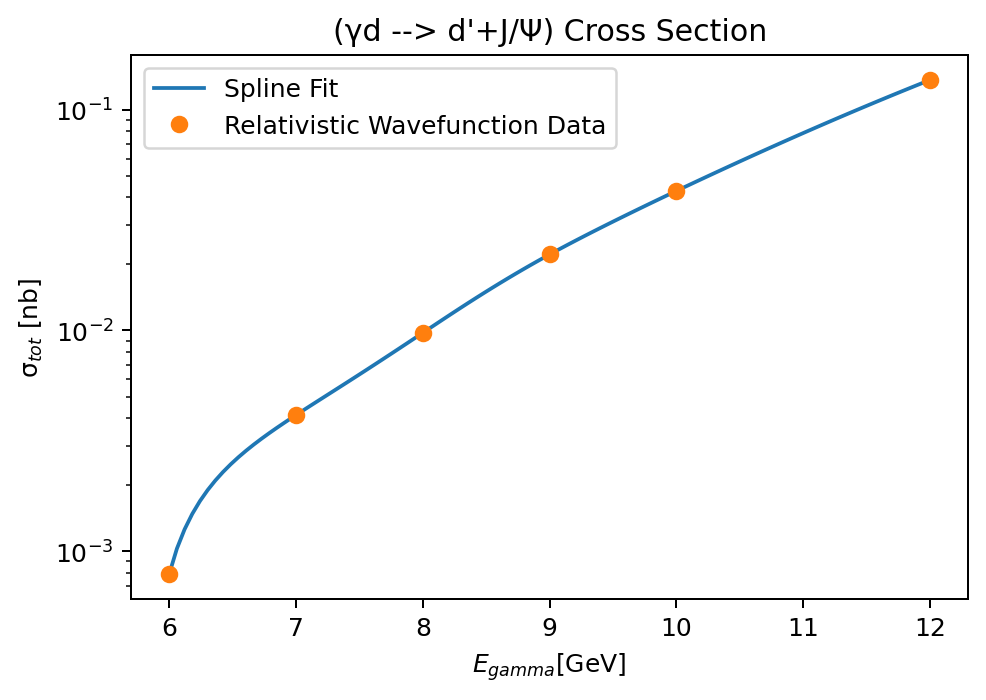

0.0010283578655418363


In [14]:
# Load the Model
df=pd.read_csv("harrymodel/JPsi_d.csv",sep="\t")
df=df.sort_values(by=['Beam Energy [GeV]','-t [GeV**2]'])
dfV=df.values
df_E=dfV[:,1]
df_T=dfV[:,2]
df_DSDT=dfV[:,3]
interp=LinearNDInterpolator(list(zip(df_E,df_T)),df_DSDT)

# Get tmin and tmax for each energy
tmtm = np.zeros((np.unique(df_E).size,3))
idxtmp=0
for tmpE in np.unique(df_E):
    tminTemp=np.where(df_E==tmpE)[0][0]
    tmaxTemp=np.where(df_E==tmpE)[0][-1]
    tmtm[idxtmp]=(tmpE,tminTemp,tmaxTemp)
    idxtmp+=1

def get_tmtm(gammaE):
    idx_of_E = np.abs(gammaE - tmtm[:,0]).argmin()
    return tmtm[idx_of_E,0],tmtm[idx_of_E,1],tmtm[idx_of_E,2]


def xsec(gammaE):
    if(gammaE<=6):
        idx=int(tmtm[tmtm[:,0] >= gammaE].min())
        DSDT_arr=df_DSDT[int(tmtm[idx,1]):int(tmtm[idx,2])]
        T_arr=df_T[int(tmtm[idx,1]):int(tmtm[idx,2])]
        return integrate.simpson(DSDT_arr,T_arr)
    gammaE_0=tmtm[tmtm[:,0] < gammaE,0].max()
    gammaE_1=tmtm[tmtm[:,0] > gammaE,0].min()
    diff=(gammaE-gammaE_0)/(gammaE_1-gammaE_0)
    idx_0=list(tmtm[:,0]).index(gammaE_0)
    idx_1=list(tmtm[:,0]).index(gammaE_1)
    DSDT_arr_0 = df_DSDT[int(tmtm[idx_0,1]):int(tmtm[idx_0,2])]
    T_arr_0 = df_T[int(tmtm[idx_0,1]):int(tmtm[idx_0,2])]
    DSDT_arr_1 = df_DSDT[int(tmtm[idx_1,1]):int(tmtm[idx_1,2])]
    T_arr_1 = df_T[int(tmtm[idx_1,1]):int(tmtm[idx_1,2])]
    diff=1-(gammaE-gammaE_0)/(gammaE_1-gammaE_0)
    return diff*integrate.simpson(DSDT_arr_0,T_arr_0)+(1-diff)*integrate.simpson(DSDT_arr_1,T_arr_1)
print(xsec(6.7))
#npoints=10
#g_arr = np.linspace(6.2,12,npoints)
g_arr = np.array([6,7,8,9,10,12])
xsec_arr = [xsec(g) for g in g_arr]
X_Y_Spline = make_interp_spline(g_arr, xsec_arr)

npoints2=100
g_arr2 = np.linspace(6,12,npoints2)
xsec_arr2 = X_Y_Spline(g_arr2)
xsec_graph=TGraph(npoints2)
for i in range(npoints2):
    xsec_graph.SetPoint(i,g_arr2[i],xsec_arr2[i])
xsec_graph.SetLineColor(2)

plt.figure(dpi=180)
plt.yscale("log")
plt.title("(γd --> d'+J/Ψ) Cross Section")
plt.xlabel("$E_{gamma}$[GeV]")
plt.ylabel("σ$_{tot}$ [nb]")
plt.plot(g_arr2,xsec_arr2,label="Spline Fit")
plt.plot(g_arr,xsec_arr,"o",label="Relativistic Wavefunction Data")
plt.legend()
plt.show()

print(xsec_graph.GetPointY(1))

In [15]:
xsec(6.7)

0.002642019920983121

In [12]:
tmtm

array([[6.00000000e+00, 0.00000000e+00, 9.70000000e+01],
       [6.04819277e+00, 9.80000000e+01, 1.99000000e+02],
       [6.09638554e+00, 2.00000000e+02, 3.05000000e+02],
       [6.14457831e+00, 3.06000000e+02, 4.14000000e+02],
       [6.19277108e+00, 4.15000000e+02, 5.27000000e+02],
       [6.24096386e+00, 5.28000000e+02, 6.43000000e+02],
       [6.28915663e+00, 6.44000000e+02, 7.63000000e+02],
       [6.33734940e+00, 7.64000000e+02, 8.86000000e+02],
       [6.38554217e+00, 8.87000000e+02, 1.01300000e+03],
       [6.43373494e+00, 1.01400000e+03, 1.14500000e+03],
       [6.48192771e+00, 1.14600000e+03, 1.28000000e+03],
       [6.53012048e+00, 1.28100000e+03, 1.41900000e+03],
       [6.57831325e+00, 1.42000000e+03, 1.56100000e+03],
       [6.62650602e+00, 1.56200000e+03, 1.70700000e+03],
       [6.67469880e+00, 1.70800000e+03, 1.85600000e+03],
       [6.72289157e+00, 1.85700000e+03, 2.00900000e+03],
       [6.77108434e+00, 2.01000000e+03, 2.16600000e+03],
       [6.81927711e+00, 2.16700

In [7]:
tVals=np.linspace(0,3,20)
eVals=np.linspace(5,10,20)
tg=TGraph2D(100*100)
i=0
for t in tVals:
    for E in eVals:
        ds=interp(E,t)
        if(ds>0):
            tg.SetPoint(i,t,E,ds)
        i=i+1

/tmp/ipykernel_2065/2282673209.py:8: RuntimeWarning: invalid value encountered in greater
  if(ds>0):


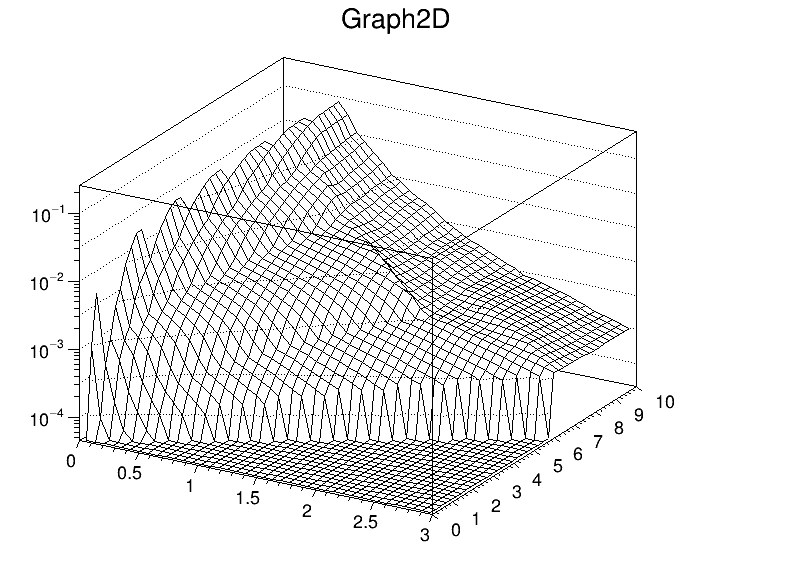

In [8]:
tg.Draw("surf")
tg.GetYaxis().SetRangeUser(5,10)
tg.GetZaxis().SetRangeUser(2e-4,0.1)
gPad.SetRightMargin(0.2)
c.SetLogz()
c.SetPhi(-30)
c.Draw()

# QSquared Reco

In [72]:
c=TCanvas("c","c",800,600)
h1=TH1F("h1",";Q^{2}_{reco} [GeV^{2}];Events",50,-2,2)
h2=TH1F("h2",";Q^{2}_{reco} [GeV^{2}];Events",50,-2,2)
tree.Draw("smear_q.M2()>>h1","acc_ePlus*acc_eMinus*acc_hOut*weight*decay_weight*flux*psf*{}/{}".format(lumi,events))
tree.Draw("smear_q.M2()>>h2","(abs(smear_q.M2())<0.02)*acc_ePlus*acc_eMinus*acc_hOut*weight*decay_weight*flux*psf*{}/{}".format(lumi,events))
h1.SetLineColor(1)
h2.SetLineColor(2)

for H in [h1,h2]:
    for BIN in range(H.GetNbinsX()+1):
        x = H.GetBinCenter(BIN)
        y = H.GetBinContent(BIN)
        ey = H.GetBinError(BIN)
        if(y!=0 and ey!=0):
            H.SetBinError(BIN,np.sqrt(y+(0.2*y)**2))

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TFile::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h2 (Potential memory leak).


564.9535827636719 [83.39848516]


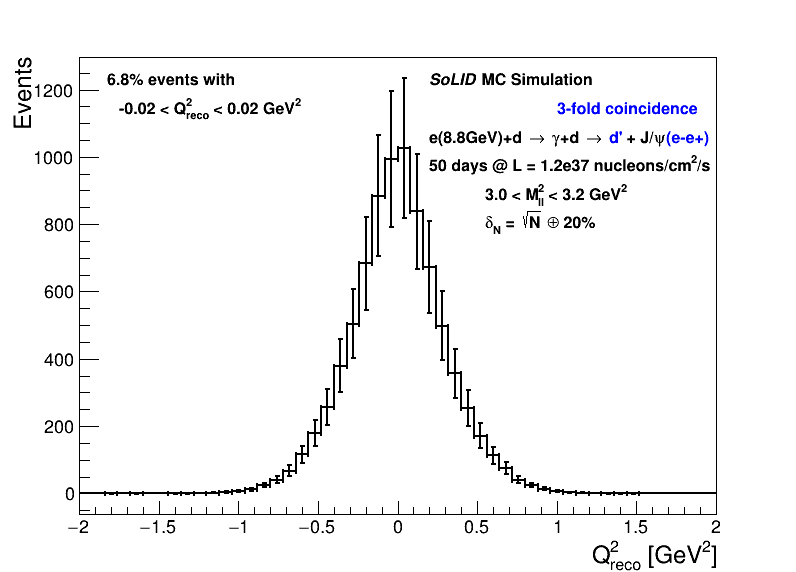

In [74]:
error = np.array([0.0])
value = h2.IntegralAndError(0,200,error)
print(value,error)

h1.Draw("hist E1")
latex.DrawLatexNDC(.54,.85,"#it{SoLID} MC Simulation")
latex.DrawLatexNDC(.7,.8,"#color[4]{3-fold coincidence}")
latex.DrawLatexNDC(.54,.75,"e({:.1f}GeV)+d #rightarrow #gamma+d #rightarrow ".format(beamE) + "#color[4]{d'} + J/#psi#color[4]{(e-e+)}")
latex.DrawLatexNDC(.54,.7,"{} days @ L = 1.2e37 nucleons/".format(days)+"cm^{2}/s")
latex.DrawLatexNDC(.61,.65,"3.0 < M_{ll}^{2} < 3.2 GeV^{2}")
latex.DrawLatexNDC(.61,.6,"#delta_{N} = #sqrt{N} #oplus 20%")
latex.DrawLatexNDC(0.135,0.85,"{:.1f}% events with".format(h2.Integral()*100/h1.Integral()))
latex.DrawLatexNDC(0.15,0.8,"-0.02 < Q^{2}_{reco} < 0.02 GeV^{2}")
c.SetLogy(0)
c.Draw()

## Photoproduction Events & Xsec vs. E_gamma

In [9]:
c=TCanvas("c","c",800,600)
Nbins=12
binXmin=6
binXmax=9
tg1=TGraphErrors(Nbins)
tg2=TGraphErrors(Nbins)
tg3=TGraphErrors(Nbins)
tg4=TGraphErrors(Nbins)
tg5=TGraphErrors(Nbins)
tg6=TGraphErrors(Nbins)
h1=TH1F("h1","h1",Nbins,binXmin,binXmax)
h1counts=TH1F("h1counts","h1counts",Nbins,binXmin,binXmax)
h1events=TH1F("h1events","h1events",Nbins,binXmin,binXmax)
h1eventsacc=TH1F("h1eventsacc","h1eventsacc",Nbins,binXmin,binXmax)
h1eventsaccD=TH1F("h1eventsaccD","h1eventsaccD",Nbins,binXmin,binXmax)
hA=TH1F("hA",";E_{#gamma} [GeV];Detected Events",Nbins,binXmin,binXmax)
tree.Draw("smear_q.E()>>h1","(abs(smear_q.M2())<0.02)*(abs(smear_VM.M()-3.1)<0.1)*weight","goff")
tree.Draw("smear_q.E()>>h1counts","(abs(smear_q.M2())<0.02)*(abs(smear_VM.M()-3.1)<0.1)","goff")
tree.Draw("smear_q.E()>>h1events","(abs(smear_q.M2())<0.02)*(abs(smear_VM.M()-3.1)<0.1)*weight*psf*decay_weight*flux*{}/{}".format(lumi,events))
tree.Draw("smear_q.E()>>h1eventsacc","(abs(smear_q.M2())<0.02)*(abs(smear_VM.M()-3.1)<0.1)*weight*psf*decay_weight*flux*{}*acc_ePlus*acc_eMinus/{}".format(lumi,events))
tree.Draw("smear_q.E()>>h1eventsaccD","(abs(smear_q.M2())<0.02)*(abs(smear_VM.M()-3.1)<0.1)*weight*psf*decay_weight*flux*{}*acc_ePlus*acc_eMinus*acc_hOut/{}".format(lumi,events))
for BIN in range(h1.GetNbinsX()+1):
    if(h1counts.GetBinContent(BIN)<1 or BIN==0):
        continue
    x = h1.GetBinCenter(BIN)
    y1 = h1.GetBinContent(BIN) / h1counts.GetBinContent(BIN)
    y2 = h1events.GetBinContent(BIN)
    y3 = h1eventsacc.GetBinContent(BIN)
    y4 = h1eventsaccD.GetBinContent(BIN)
    tg1.SetPoint(BIN,x,y1)
    tg2.SetPoint(BIN,x,y2)
    tg3.SetPoint(BIN,x,y3)
    tg6.SetPoint(BIN,x,y4)
    if(y3!=0):
        tg4.SetPoint(BIN,x,X_Y_Spline(x))
        tg5.SetPoint(BIN,x,X_Y_Spline(x))
        #tg4.SetPoint(BIN,x,y1)
    tg1.SetPointError(BIN,0,np.sqrt(y1))
    tg2.SetPointError(BIN,0,np.sqrt(y2))
    tg3.SetPointError(BIN,0,np.sqrt(y3))
    tg6.SetPointError(BIN,0,np.sqrt(y4+(0.2*y4)**2))
    if(y3!=0):
        tg4.SetPointError(BIN,0,X_Y_Spline(x)/np.sqrt(y3))
        tg5.SetPointError(BIN,0,X_Y_Spline(x)*np.sqrt(1/y4+0.04))
    hA.SetBinContent(BIN,tg6.GetPointY(BIN))
    hA.SetBinError(BIN,tg6.GetErrorY(BIN))
    
tg1.SetMarkerStyle(20)
tg1.GetXaxis().SetLimits(binXmin,binXmax)
tg1.GetYaxis().SetRangeUser(0.0005,0.01)

tg2.SetMarkerStyle(20)
tg2.GetXaxis().SetLimits(binXmin,binXmax)
tg2.GetYaxis().SetRangeUser(1,10000)
tg2.SetTitle(";E_{#gamma} [GeV];Events")

tg3.SetMarkerStyle(20)
tg3.GetXaxis().SetLimits(binXmin,binXmax)
tg3.GetYaxis().SetRangeUser(.1,2000)
tg3.SetTitle(";E_{#gamma} [GeV];Detected Events")

tg6.SetMarkerStyle(20)
tg6.GetXaxis().SetLimits(binXmin,binXmax)
tg6.GetYaxis().SetRangeUser(.1,2000)
tg6.SetTitle(";E_{#gamma} [GeV];Detected Events")

tg4.SetMarkerStyle(20)
tg4.GetXaxis().SetLimits(binXmin,binXmax+.3)
tg4.GetYaxis().SetRangeUser(0.00005,0.1)
tg4.SetTitle(";E_{#gamma} [GeV];#sigma [nb]")

tg5.SetMarkerStyle(20)
tg5.GetXaxis().SetLimits(binXmin,binXmax+.3)
tg5.GetYaxis().SetRangeUser(0.00005,0.1)
tg5.SetTitle(";E_{#gamma} [GeV];#sigma [nb]")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


563.0950012542307 [48.08206503]


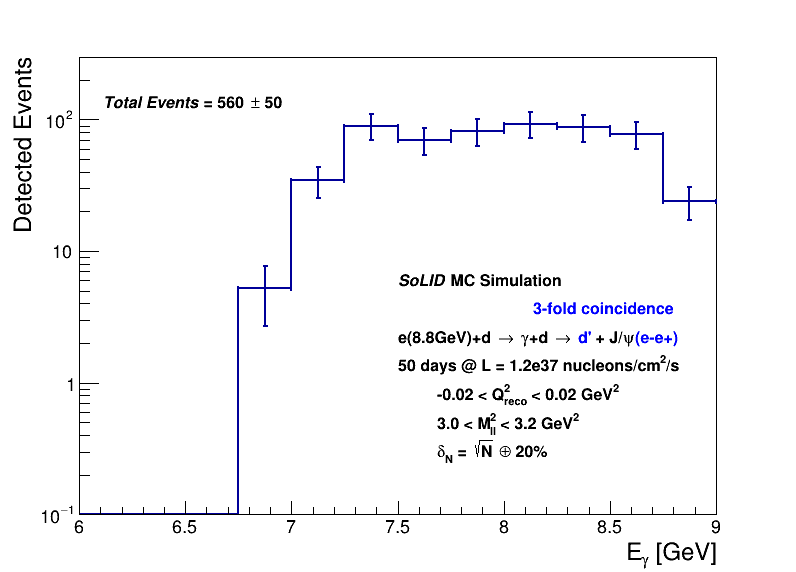

In [10]:
c.SetLeftMargin(0.1)
hA.GetYaxis().SetRangeUser(0.1,300)
hA.Draw("hist E1")
error = np.array([0.0])
value = hA.IntegralAndError(0,200,error)
print(value,error)
latex.DrawLatexNDC(0.13,.81,"#it{Total Events}"+" = {} #pm {}".format(np.round(int(value),-1),np.round(int(error),-1)))
latex.DrawLatexNDC(.5,.5,"#it{SoLID} MC Simulation")
latex.DrawLatexNDC(.67,.45,"#color[4]{3-fold coincidence}")
latex.DrawLatexNDC(.5,.4,"e({:.1f}GeV)+d #rightarrow #gamma+d #rightarrow ".format(beamE) + "#color[4]{d'} + J/#psi#color[4]{(e-e+)}")
latex.DrawLatexNDC(.5,.35,"{} days @ L = 1.2e37 nucleons/".format(days)+"cm^{2}/s")
latex.DrawLatexNDC(.55,.3,"-0.02 < Q^{2}_{reco} < 0.02 GeV^{2}")
latex.DrawLatexNDC(.55,.25,"3.0 < M_{ll}^{2} < 3.2 GeV^{2}")
latex.DrawLatexNDC(.55,.2,"#delta_{N} = #sqrt{N} #oplus 20%")
c.SetLogy(1)
c.Draw()

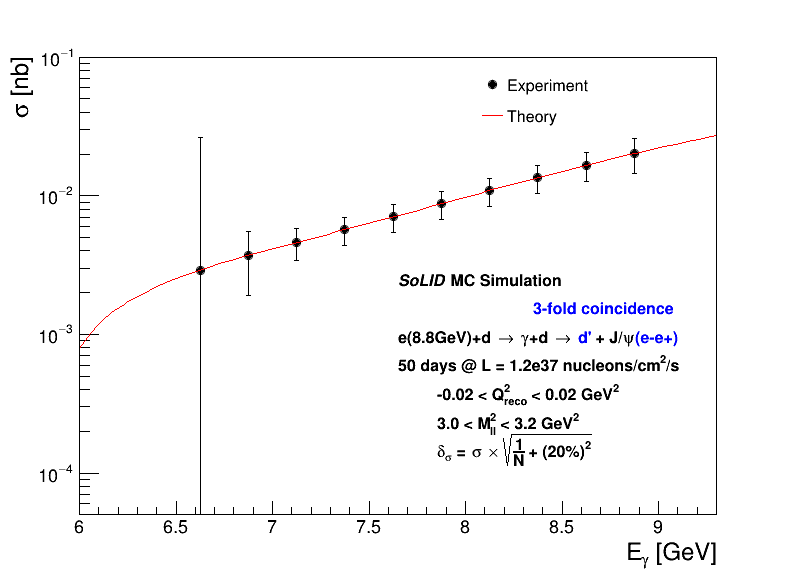

In [11]:
c.SetLeftMargin(0.1)
tg5.Draw("AP+")
latex.DrawLatexNDC(.5,.5,"#it{SoLID} MC Simulation")
latex.DrawLatexNDC(.67,.45,"#color[4]{3-fold coincidence}")
latex.DrawLatexNDC(.5,.4,"e({:.1f}GeV)+d #rightarrow #gamma+d #rightarrow ".format(beamE) + "#color[4]{d'} + J/#psi#color[4]{(e-e+)}")
latex.DrawLatexNDC(.5,.35,"{} days @ L = 1.2e37 nucleons/".format(days)+"cm^{2}/s")
latex.DrawLatexNDC(.55,.3,"-0.02 < Q^{2}_{reco} < 0.02 GeV^{2}")
latex.DrawLatexNDC(.55,.25,"3.0 < M_{ll}^{2} < 3.2 GeV^{2}")
latex.DrawLatexNDC(.55,.2,"#delta_{#sigma} = #sigma #times #sqrt{#frac{1}{N} + (20%)^{2}}")
tg1.SetLineColor(2)
xsec_graph.Draw("C same")
#tg1.Draw("C same")
legend=TLegend(0.6,0.77,0.75,0.88)
legend.SetBorderSize(0)
legend.AddEntry(tg5,"Experiment","p")
legend.AddEntry(tg1,"Theory","l")
legend.Draw()
c.SetLogy(1)
c.Draw()

# Acceptance

In [16]:
c=TCanvas("c","c",800,600)
Nbins=40
binXmin=6
binXmax=9
tg1=TGraphErrors(Nbins)
tg2=TGraphErrors(Nbins)
h1noqcuts=TH1F("h1noqcuts","h1noqcuts",Nbins,binXmin,binXmax)
h1events=TH1F("h1events","h1events",Nbins,binXmin,binXmax)
h1eventsaccD=TH1F("h1eventsaccD","h1eventsaccD",Nbins,binXmin,binXmax)
tree.Draw("smear_q.E()>>h1noqcuts","(abs(smear_VM.M()-3.1)<0.1)*weight*psf*decay_weight*flux*{}/{}".format(lumi,events),"goff")
tree.Draw("smear_q.E()>>h1events","(abs(smear_q.M2())<0.02)*(abs(smear_VM.M()-3.1)<0.1)*weight*psf*decay_weight*flux*{}/{}".format(lumi,events))
tree.Draw("smear_q.E()>>h1eventsaccD","(abs(smear_q.M2())<0.02)*(abs(smear_VM.M()-3.1)<0.1)*weight*psf*decay_weight*flux*{}*acc_ePlus*acc_eMinus*acc_hOut/{}".format(lumi,events))
for BIN in range(h1noqcuts.GetNbinsX()+1):
    if(h1noqcuts.GetBinContent(BIN)<1 or BIN==0):
        continue
    x = h1noqcuts.GetBinCenter(BIN)
    y2 = h1events.GetBinContent(BIN)
    y4 = h1eventsaccD.GetBinContent(BIN)
    y5 = h1noqcuts.GetBinContent(BIN)
    if(y5!=0):
        tg1.SetPoint(BIN,x,y2/y5)
        tg2.SetPoint(BIN,x,y4/y5)
        tg1.SetPointError(BIN,0,0)
        tg2.SetPointError(BIN,0,0)

tg1.SetMarkerStyle(20)
tg1.GetXaxis().SetLimits(binXmin,binXmax)
tg1.GetYaxis().SetRangeUser(.001,2)
tg1.SetTitle(";E_{#gamma} [GeV];Acceptance")


tg2.SetMarkerStyle(20)
tg2.GetXaxis().SetLimits(binXmin,binXmax)
tg2.GetYaxis().SetRangeUser(.001,2)
tg2.SetTitle(";E_{#gamma} [GeV];Detected Events")


KeyboardInterrupt: 

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


In [103]:
gStyle.SetTitleYOffset(.5)
gStyle.SetTitleXSize(3*0.035)
gStyle.SetTitleYSize(3*0.035)


hB=TH1F("hB",";E_{#gamma} [GeV];Acceptance",Nbins,binXmin,binXmax)
hB.Clear()
hB.Add(h1eventsaccD)
hB.Divide(h1events)
tg3=TGraphErrors(Nbins)
for BIN in range(hB.GetNbinsX()+1):
    x=hB.GetBinCenter(BIN)
    y=hB.GetBinContent(BIN)
    ey=hB.GetBinError(BIN)
    tg3.SetPoint(BIN,x,y)
    tg3.SetPointError(BIN,0,ey)

Warning in <TFile::Append>: Replacing existing TH1: hB (Potential memory leak).


Warning in <TCanvas::Constructor>: Deleting canvas with same name: csplit


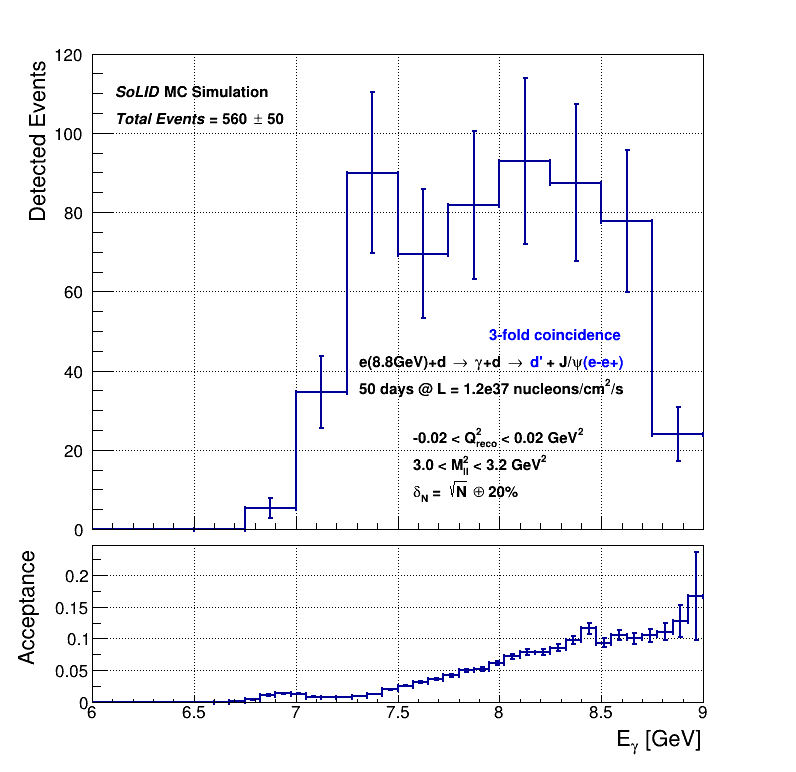

In [104]:
from ROOT import TPad
csplit=TCanvas("csplit","csplit",800,800)
p1 = TPad("p1","p1",0.02,0.3,0.98,1,0)
p1.Draw()
p2 = TPad("p2","p2",0.02,0,0.98,0.3,0)
p2.Draw()
p1.SetBottomMargin(0.02)
p2.SetTopMargin(0.02)
p2.SetBottomMargin(.3)

p1.cd()
hA.Draw("hist E1")
hA.GetYaxis().SetRangeUser(0,120)
hA.GetXaxis().SetLabelOffset(100)
hA.GetYaxis().SetLabelOffset(0.01)
#gPad.SetRightMargin(0.1)
#gPad.SetTopMargin(0.1)
#gPad.SetBottomMargin(0.013)
gPad.SetGrid()

latex.DrawLatexNDC(.13,.82,"#it{SoLID} MC Simulation")
latex.DrawLatexNDC(0.13,.77,"#it{Total Events}"+" = {} #pm {}".format(np.round(int(value),-1),np.round(int(error),-1)))
latex.DrawLatexNDC(.62,.37,"#color[4]{3-fold coincidence}")
latex.DrawLatexNDC(.45,.32,"e({:.1f}GeV)+d #rightarrow #gamma+d #rightarrow ".format(beamE) + "#color[4]{d'} + J/#psi#color[4]{(e-e+)}")
latex.DrawLatexNDC(.45,.27,"{} days @ L = 1.2e37 nucleons/".format(days)+"cm^{2}/s")
latex.DrawLatexNDC(.52,.18,"-0.02 < Q^{2}_{reco} < 0.02 GeV^{2}")
latex.DrawLatexNDC(.52,.13,"3.0 < M_{ll}^{2} < 3.2 GeV^{2}")
latex.DrawLatexNDC(.52,.08,"#delta_{N} = #sqrt{N} #oplus 20%")

p2.cd()
hB.Draw("hist E1")
hB.GetXaxis().SetLabelSize(0.08)
hB.GetYaxis().SetLabelSize(0.08)
hB.GetYaxis().SetNdivisions(305)
gPad.SetGrid()

csplit.Draw()

## Nevents

In [17]:
total_evts=[0,0]
total_evts_acc=[0,0]
total_evts_acc_D=[0,0]
for i in range(Nbins):
    evts=tg2.GetPointY(i)
    evts_err=tg2.GetErrorY(i)
    
    evts_D=tg6.GetPointY(i)
    evts_acc=tg3.GetPointY(i)
    evts_err_D=tg6.GetErrorY(i)
    evts_acc_err=tg3.GetErrorY(i)
    total_evts[0]+=evts
    total_evts_acc[0]+=evts_acc
    total_evts_acc_D[0]+=evts_D
    total_evts[1]+=evts_err**2
    total_evts_acc[1]+=evts_acc_err**2
    total_evts_acc_D[1]+=evts_err_D**2
total_evts[1]=np.sqrt(total_evts[1])
total_evts_acc[1]=np.sqrt(total_evts_acc[1])
total_evts_acc_D[1]=np.sqrt(total_evts_acc_D[1])
print("Photooproduction \n eBeam = ",beamE,"GeV and Virtual Photon E <= 8.2 GeV | Total Events |-->",np.round(total_evts[0],3),"+/-",np.round(total_evts[1],3))
print("Photoproduction \n eBeam = ",beamE,"GeV and Virtual Photon E <= 8.2 GeV | Total Accepted Events (2-fold) |-->",np.round(total_evts_acc[0],3),"+/-",np.round(total_evts_acc[1],3))
print("Photoproduction \n eBeam = ",beamE,"GeV and Virtual Photon E <= 8.2 GeV | Total Accepted Events (3-fold) |-->",np.round(total_evts_acc_D[0],3),"+/-",np.round(total_evts_acc_D[1],3))

Photooproduction 
 eBeam =  8.8 GeV and Virtual Photon E <= 8.2 GeV | Total Events |--> 25405.228 +/- 159.39
Photoproduction 
 eBeam =  8.8 GeV and Virtual Photon E <= 8.2 GeV | Total Accepted Events (2-fold) |--> 2645.569 +/- 51.435
Photoproduction 
 eBeam =  8.8 GeV and Virtual Photon E <= 8.2 GeV | Total Accepted Events (3-fold) |--> 1860.667 +/- 43.135


Warning in <TFile::Append>: Replacing existing TH1: h2 (Potential memory leak).


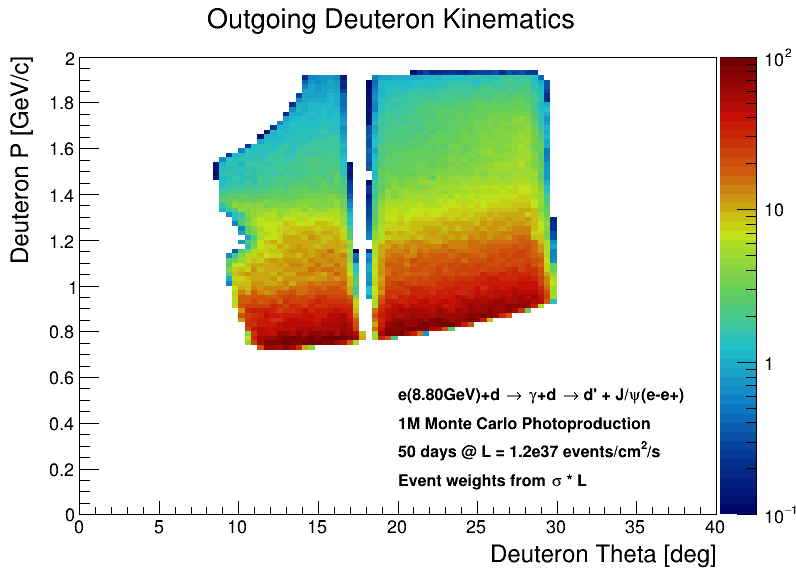

In [18]:
h2=TH2F("h2","Outgoing Deuteron Kinematics;Deuteron Theta [deg];Deuteron P [GeV/c]",100,0,40,100,0,2)
tree.Draw("p_D:th_D>>h2","weight*{}/{}*acc_dOut".format(lumi,events),"colz")
h2.Draw("colz")
h2.GetZaxis().SetRangeUser(0.1,100)
latex.DrawLatexNDC(.5,.3,"e({:.2f}GeV)+d #rightarrow #gamma+d #rightarrow d' + J/#psi(e-e+)".format(beamE))
latex.DrawLatexNDC(.5,.25,eventtxt)
latex.DrawLatexNDC(.5,.2,"{} days @ L = 1.2e37 events/".format(days)+"cm^{2}/s")
latex.DrawLatexNDC(.5,.15,"Event weights from #sigma * L")
line5=TLine(8,0,8,2)
line6=TLine(26,0.6,26,2)
line5.SetLineColor(2)
line6.SetLineColor(2)
#line5.Draw()
#line6.Draw()
c.SetLogy(0)
c.SetLogz(1)
c.Draw()

# Bethe Heitler Background

In [19]:
events_BH=1000000
inFile_BH=TFile("../BHoffD/data/test_py_beamE_{:.2f}_evts_{}_batch_0.root".format(beamE,events_BH),"READ")
tree_BH=inFile_BH.Get("tree")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


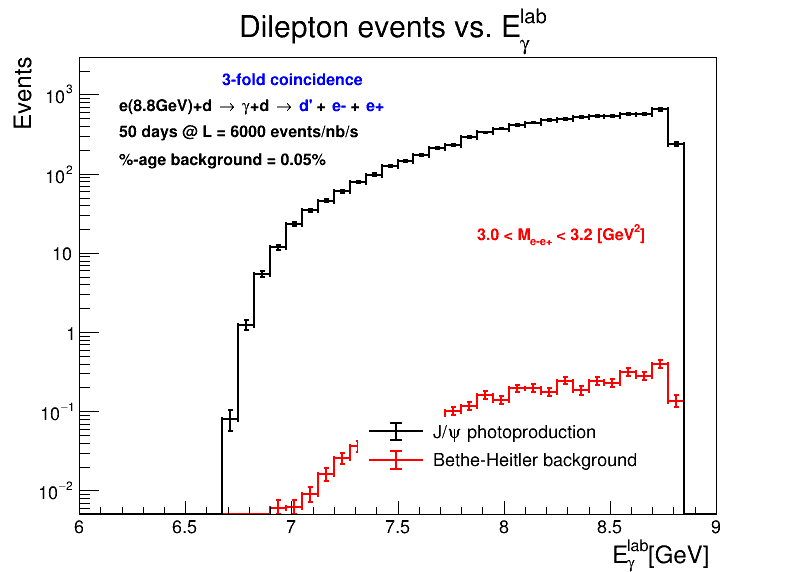

In [20]:
c=TCanvas("c","c",800,600)
minE,maxE,stepE=6,9,40
binE=(maxE-minE)/stepE*1000
h1 = TH1F("h1","Dilepton events vs. E^{lab}_{#gamma} ;E^{lab}_{#gamma}[GeV] ;"+"Events",stepE,minE,maxE)
h2 = TH1F("h2","Dilepton events vs. E^{lab}_{#gamma} ;E^{lab}_{#gamma}[GeV] ;"+"Events",stepE,minE,maxE)
h3 = TH1F("h3","".format(binE),stepE,minE,maxE)
tree_BH.Draw("gammaE>>h1","(m_vm>2.5&&m_vm<3.5)*acc_photo*weight*{}/{}".format(lumi,events_BH),"goff")
tree_BH.Draw("gammaE>>h2","(m_vm>3&&m_vm<3.2)*acc_photo*weight*{}/{}".format(lumi,events_BH),"goff")
tree.Draw("gammaE>>h3","acc_photo*weight*{}/{}".format(lumi,events),"goff")
h2.GetYaxis().SetRangeUser(0.005,3000)
h1.SetLineColor(1)
h2.SetLineColor(2)
h3.SetLineColor(1)
#h1.Draw("hist E1")
h2.Draw("hist E1")
h3.Draw("same hist E1")
c.SetLogy(1)

latex.DrawLatexNDC(.28,.85,"#color[4]{3-fold coincidence}")
latex.DrawLatexNDC(.15,.805,"e({:.1f}GeV)+d #rightarrow #gamma+d #rightarrow ".format(beamE)+"#color[4]{d'} + #color[4]{e-} + #color[4]{e+}")
latex.DrawLatexNDC(.15,.76,"{} days @ L = 6000 events/".format(days)+"nb/s")
latex.DrawLatexNDC(.15,.71,"%-age background = "+str(np.round(100*h2.Integral()/h3.Integral(),2))+"%")
latex.DrawLatexNDC(.6,.58,"#color[2]{3.0 < M_{e-e+} < 3.2 [GeV^{2}]}")
legend=TLegend(0.45,0.17,0.83,0.27)
legend.SetBorderSize(0)
legend.AddEntry(h3,"J/#psi photoproduction","le")
legend.AddEntry(h2,"Bethe-Heitler background","le")
legend.Draw("same")
c.Draw()


# Cross Section Comparison

In [21]:
minE,maxE,stepE=6,8.4,12
h1 = TH1F("h1","",stepE,minE,maxE)
h1s = TH1F("h1s","",stepE,minE,maxE)
h1countsacc = TH1F("h1countsacc","",stepE,minE,maxE)
# h1 --> counts times an energy bin is filled
# h1s --> accumulates cross section weight per event (without photon flux)
# h1countsacc --> accumulates number of events expected by the experiment within the energy bin
tree_BH.Draw("gammaE>>h1","","goff")
tree_BH.Draw("gammaE>>h1s","dsdtdMll2*psf","goff")
tree_BH.Draw("gammaE>>h1countsacc","acc_photo*weight*{}/{}".format(lumi,events_BH),"goff")
tg = TGraphErrors(stepE)
for BIN in range(h1countsacc.GetNbinsX()):
    if(h1.GetBinContent(BIN)<10):
        continue
    x = h1countsacc.GetBinCenter(BIN)
    # Average cross section filled into bin
    # y = (Sum of cross section in bin) / (Number of entries in bin)
    y = h1s.GetBinContent(BIN) / h1.GetBinContent(1) / 1.25
    tg.SetPoint(BIN,x,y)
    tg.SetPointError(BIN,0,y/np.sqrt(h1.GetBinContent(BIN)))
tg.SetMarkerStyle(22)
tg.SetMarkerColor(2)
tg.SetMarkerSize(1.5)
tg.GetXaxis().SetRangeUser(6,8.5)
tg.GetYaxis().SetRangeUser(1e-3,100)

Warning in <TFile::Append>: Replacing existing TH1: h1 (Potential memory leak).


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


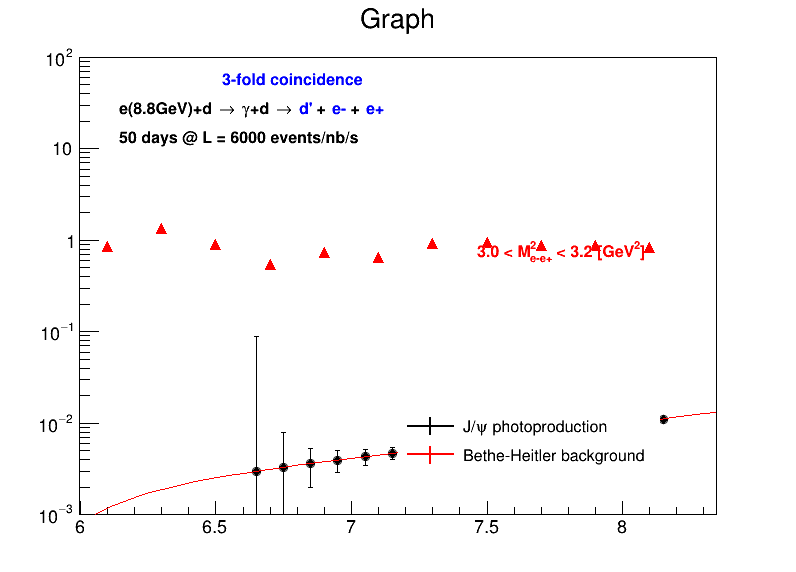

In [22]:
c=TCanvas("c","c",800,600)
tg.Draw("AP+")
tg5.Draw("P+ same")
xsec_graph.Draw("C same")

latex.DrawLatexNDC(.28,.85,"#color[4]{3-fold coincidence}")
latex.DrawLatexNDC(.15,.8,"e({:.1f}GeV)+d #rightarrow #gamma+d #rightarrow ".format(beamE)+"#color[4]{d'} + #color[4]{e-} + #color[4]{e+}")
latex.DrawLatexNDC(.15,.75,"{} days @ L = 6000 events/".format(days)+"nb/s")
latex.DrawLatexNDC(.6,.55,"#color[2]{3.0 < M_{e-e+}^{2} < 3.2 [GeV^{2}]}")
legend=TLegend(0.5,0.18,0.83,0.28)
legend.SetBorderSize(0)
legend.AddEntry(h3,"J/#psi photoproduction","le")
legend.AddEntry(h2,"Bethe-Heitler background","le")
legend.Draw("same")

c.SetLogy(1)
c.Draw()

0.0012824184523369127
1.0
9.838704444468021 7671.992263164371


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TFile::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h3 (Potential memory leak).


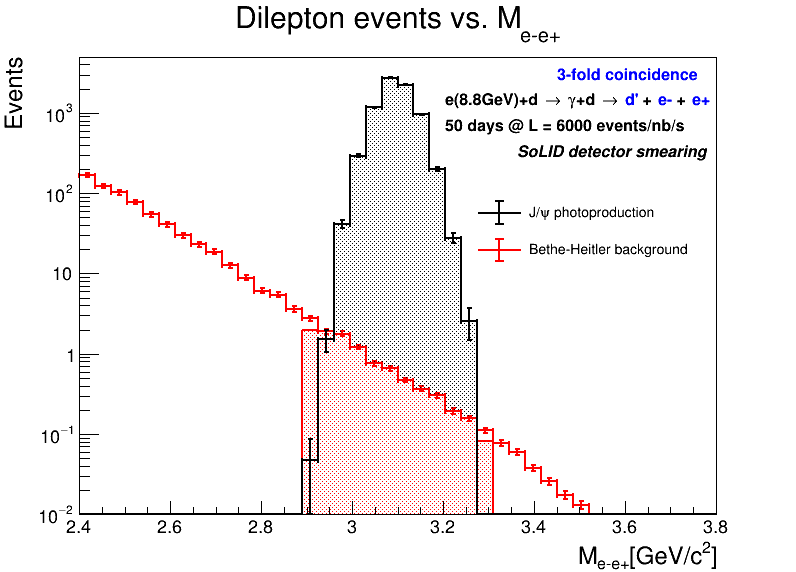

In [23]:
c=TCanvas("c","c",800,600)
xmin,xmax,xstep=2.4,3.8,40
h1=TH1F("h1",";M_{e-e+}[GeV/c^{2}];"+"Events",xstep,xmin,xmax)
h2=TH1F("h2","Dilepton events vs. M_{e-e+};M_{e-e+}[GeV/c^{2}];"+"Events",xstep,xmin,xmax)
h3=TH1F("h3",";M_{e-e+}[GeV/c^{2}];"+"Events",xstep,xmin,xmax)
h4=TH1F("h4",";M_{e-e+}[GeV/c^{2}];"+"Events",xstep,xmin,xmax)
h5=TH1F("h5",";M_{e-e+}[GeV/c^{2}];"+"Events",xstep,xmin,xmax)
tree_BH.Draw("smear_m_vm>>h1","weight*{}/{}".format(lumi,events_BH),"goff")
tree_BH.Draw("smear_m_vm>>h2","acc_photo*weight*{}/{}".format(lumi,events_BH),"goff")
tree_BH.Draw("smear_m_vm>>h3","(smear_m_vm>2.9&&smear_m_vm<3.3)*acc_photo*weight*{}/{}".format(lumi,events_BH),"goff")
tree.Draw("smear_m_vm>>h4","acc_photo*weight*{}/{}".format(lumi,events),"goff")
tree.Draw("smear_m_vm>>h5","(smear_m_vm>2.9&&smear_m_vm<3.3)*acc_photo*weight*{}/{}".format(lumi,events),"goff")
h1.SetLineColor(1)
h2.SetLineColor(2)
h3.SetLineColor(2)
h3.SetFillColor(2)
h4.SetLineColor(1)
h5.SetFillColor(1)
h5.SetLineColor(1)
h3.SetFillStyle(3003)
h5.SetFillStyle(3003)
h2.GetYaxis().SetRangeUser(0.01,5000)
h2.GetYaxis().SetTitleOffset(1.15)
#h1.Draw("goff")
h2.Draw("hist E1")
h5.Draw("hist same")
h3.Draw("hist same")
h4.Draw("hist E1 same")
c.SetLogy(1)
gStyle.SetPadGridY(1)
gPad.RedrawAxis()
print(h3.Integral()/h5.Integral())
print(h5.Integral()/h4.Integral())
print(h3.Integral(),h5.Integral())
latex.DrawLatexNDC(.7,.86,"#color[4]{3-fold coincidence}")
latex.DrawLatexNDC(.56,.815,"e({:.1f}GeV)+d #rightarrow #gamma+d #rightarrow ".format(beamE)+"#color[4]{d'} + #color[4]{e-} + #color[4]{e+}")
latex.DrawLatexNDC(.56,.77,"{} days @ L = 6000 events/".format(days)+"nb/s")
latex.DrawLatexNDC(.65,.725,"#it{SoLID detector smearing}")
legend=TLegend(0.59,0.53,0.89,0.66)
legend.SetBorderSize(0)
legend.AddEntry(h4,"J/#psi photoproduction","le")
legend.AddEntry(h2,"Bethe-Heitler background","le")
legend.Draw("same")
c.Draw()

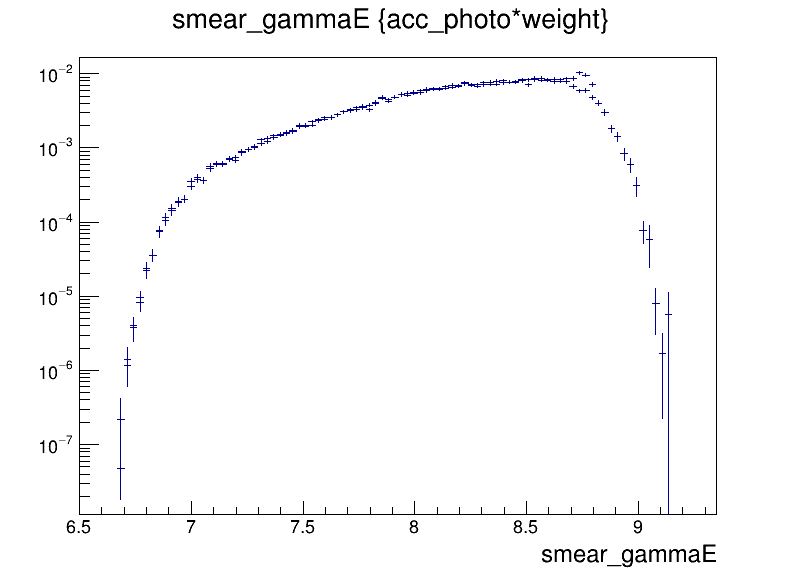

In [24]:
tree.Draw("smear_gammaE","acc_photo*weight")
tree.Draw("gammaE","acc_photo*weight","same")
c.Draw()

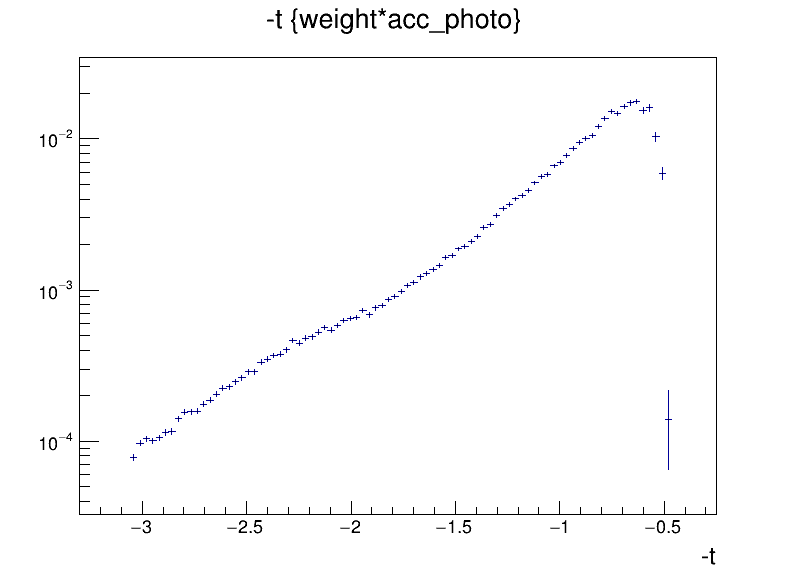

In [25]:
tree.Draw("-t","weight*acc_photo")
c.Draw()

# 4/19/2022 Analysis

In [6]:
f_pom = TFile("./data/test_py_ep_beamE_11.00_evts_1000000_process_photo_detector_SoLID_model_PomeronLQCD.root","r")
t_pom = f_pom.Get("tree")

f_23g = TFile("./data/test_py_ep_beamE_11.00_evts_1000000_process_photo_detector_SoLID_model_23g.root","r")
t_23g = f_23g.Get("tree")
c=TCanvas("c","c",800,600)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


# GlueX data

In [7]:
energy_bins_GX = np.array([[8.2,8.56],[8.56,8.92],[8.92,9.28],[9.28,9.64],[9.64,10],[10,10.36],[10.36,10.72],[10.72,11.08],[11.08,11.44],[11.44,11.8]])
sigmas_GX      = np.array([0.116,0.343,0.313,0.835,0.868,0.949,1.383,1.274,2.158,3.245])
errors_GX      = np.array([[0.031,0.013],[0.067,0.082],[0.127,0.052],[0.194,0.185],[0.196,0.109],[0.187,0.102],[0.284,0.323],[0.206,0.184],[0.421,0.657],[0.928,0.384]])

energies_GX    = np.mean(energy_bins_GX,axis=1)
errors_GX      = np.sqrt(errors_GX[:,0]**2+errors_GX[:,1]**2)
n = energies_GX.size
tg_GlueX = TGraphErrors(n,energies_GX,sigmas_GX,np.zeros(n),errors_GX)
tg_GlueX.SetMarkerStyle(33)
tg_GlueX.SetMarkerSize(3)
tg_GlueX.SetMarkerColor(2)
tg_GlueX.SetLineColor(2)

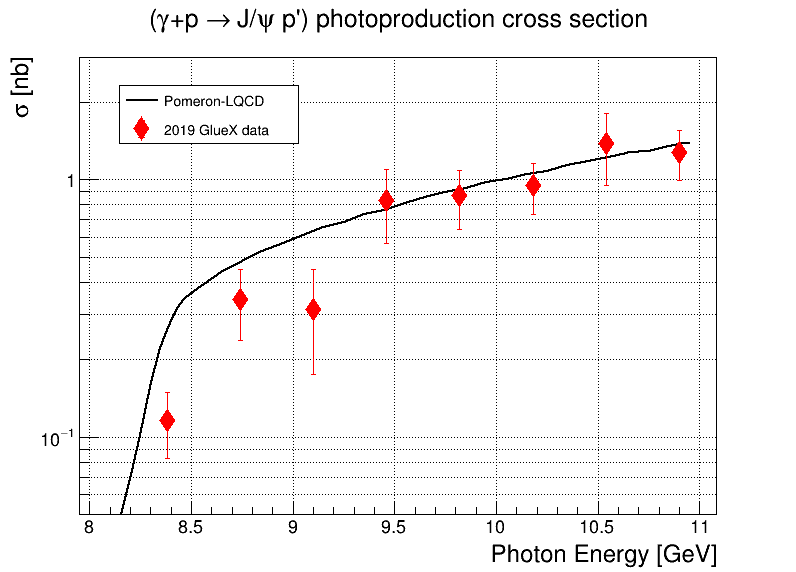

In [8]:
eMin=8
eMax=11
bins=30

hCounts = TH1F("hCounts","hCounts",bins,eMin,eMax)
hWeight = TH1F("hWeight","hWeight",bins,eMin,eMax)
tge_pom=TGraphErrors(bins)
tge_pom.SetLineWidth(2)
t_pom.Draw("gammaE>>hCounts","","goff")
t_pom.Draw("gammaE>>hWeight","weight*psf","goff")
for i in range(0,bins):
    if(hCounts.GetBinContent(i+1)==0):
        continue
    tge_pom.SetPoint(i,hCounts.GetBinCenter(i+1),hWeight.GetBinContent(i+1)/hCounts.GetBinContent(i+1))
    tge_pom.SetPointError(i,0,hWeight.GetBinError(i+1)/hCounts.GetBinContent(i+1))
tge_pom.Draw("AC")
tg_GlueX.Draw("P same")

tge_pom.GetXaxis().SetRangeUser(eMin,eMax)
tge_pom.GetYaxis().SetRangeUser(0.05,3)
tge_pom.SetMarkerStyle(20)
tge_pom.SetTitle("(#gamma+p #rightarrow J/#psi p') photoproduction cross section; Photon Energy [GeV]; #sigma [nb]")
gPad.SetGrid()
c.SetLogy(1)
legend = TLegend(0.15,0.75,0.375,0.85)
legend.AddEntry(tge_pom,"Pomeron-LQCD","l")
legend.AddEntry(tg_GlueX,"2019 GlueX data","pe")
legend.Draw()
c.Draw()

Warning in <TFile::Append>: Replacing existing TH1: hCounts (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hWeight (Potential memory leak).


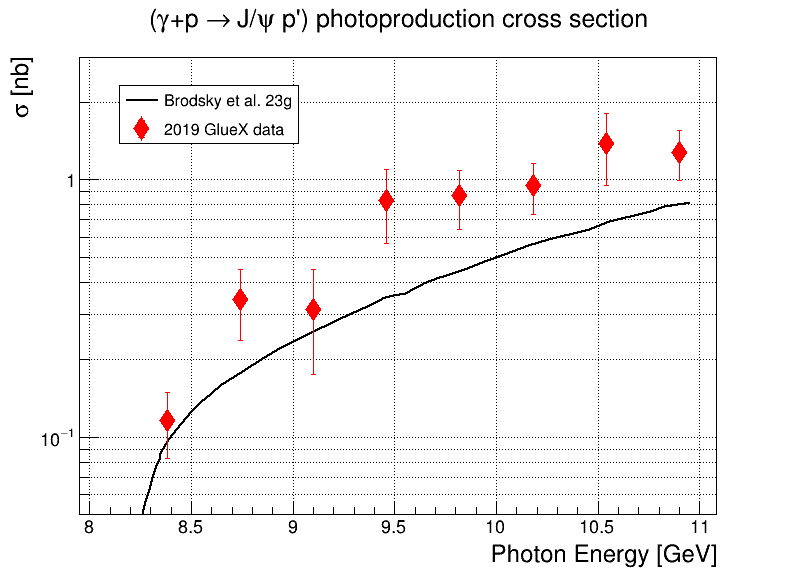

In [9]:
eMin=8
eMax=11
bins=30
hCounts = TH1F("hCounts","hCounts",bins,eMin,eMax)
hWeight = TH1F("hWeight","hWeight",bins,eMin,eMax)
tge_23g=TGraphErrors(bins)
tge_23g.SetLineWidth(2)
tge_23g.SetLineStyle(1)
t_23g.Draw("gammaE>>hCounts","","goff")
t_23g.Draw("gammaE>>hWeight","weight*psf","goff")
for i in range(0,bins):
    if(hCounts.GetBinContent(i+1)==0):
        continue
    tge_23g.SetPoint(i,hCounts.GetBinCenter(i+1),hWeight.GetBinContent(i+1)/hCounts.GetBinContent(i+1))
    tge_23g.SetPointError(i,0,hWeight.GetBinError(i+1)/hCounts.GetBinContent(i+1))
tge_23g.Draw("AC")
tg_GlueX.Draw("P same")
tge_23g.GetXaxis().SetRangeUser(eMin,eMax)
tge_23g.GetYaxis().SetRangeUser(0.05,3)
tge_23g.SetMarkerStyle(20)
tge_23g.SetTitle("(#gamma+p #rightarrow J/#psi p') photoproduction cross section; Photon Energy [GeV]; #sigma [nb]")
gPad.SetGrid()
c.SetLogy(1)
legend = TLegend(0.15,0.75,0.375,0.85)
legend.AddEntry(tge_23g,"Brodsky et al. 23g","l")
legend.AddEntry(tg_GlueX,"2019 GlueX data","pe")
legend.Draw()
c.Draw()

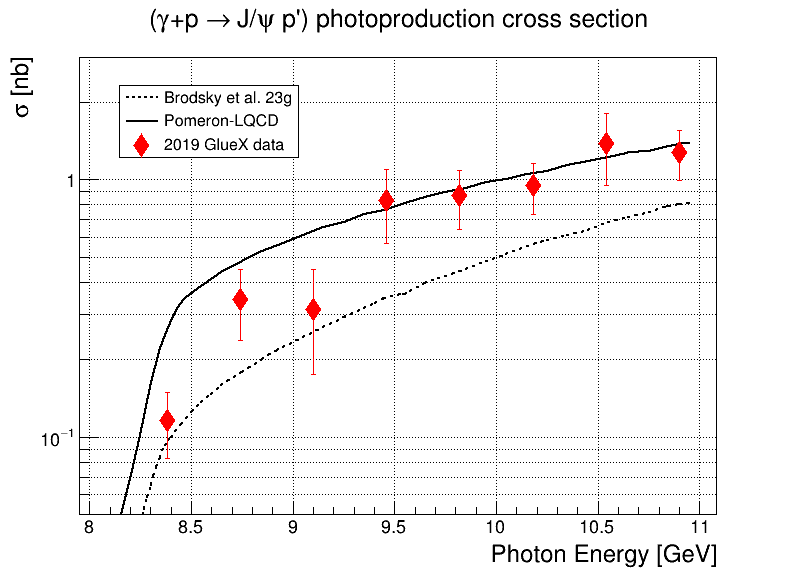

In [10]:
tge_23g.Draw("AC")
tge_23g.SetLineStyle(2)
tge_pom.Draw("C same")
tg_GlueX.Draw("P same")
legend = TLegend(0.15,0.725,0.375,0.85)
legend.AddEntry(tge_23g,"Brodsky et al. 23g","l")
legend.AddEntry(tge_pom,"Pomeron-LQCD","l")
legend.AddEntry(tg_GlueX,"2019 GlueX data","pe")
legend.Draw("same")
c.Draw()

# CLAS12 (w/o EPA)

In [38]:
lumi_clas12 = 206019450.0
evts_clas12 = 5e6

In [127]:
f_clas12_coherent = TFile("./data/test_py_ed_beamE_11.00_evts_5000000_process_photo_coherent_detector_CLAS12_model_PomeronLQCD.root","r")
t_clas12_coherent = f_clas12_coherent.Get("tree")

f_clas12_incoherent = TFile("./data/test_py_ed_beamE_11.00_evts_5000000_process_photo_incoherent_detector_CLAS12_model_PomeronLQCD.root","r")
t_clas12_incoherent = f_clas12_incoherent.Get("tree")

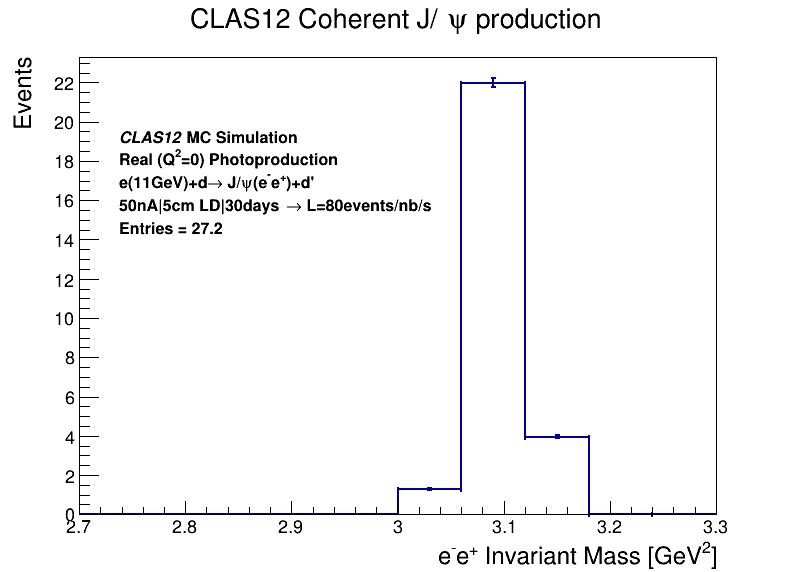

In [128]:
h_coherent = TH1F("h_coherent","CLAS12 Coherent J/#psi production;e^{-}e^{+} Invariant Mass [GeV^{2}];Events",10,2.7,3.3)
t_clas12_coherent.Draw("m_vm_smear>>h_coherent","weight*psf*flux*decay_weight*acc_hOut*acc_eMinus*acc_ePlus*{}/{}".format(lumi_clas12,evts_clas12),"hist e1")
c.Draw()
gPad.SetGrid(0,0)
error=np.array([0.0])
integral=h_coherent.IntegralAndError(0,10,error)
latex.DrawLatexNDC(0.15,0.75,"#it{CLAS12} MC Simulation")
latex.DrawLatexNDC(0.15,0.71,"Real (Q^{2}=0) Photoproduction")
latex.DrawLatexNDC(0.15,0.67,"e(11GeV)+d#rightarrow J/#psi(e^{-}e^{+})+d'")
latex.DrawLatexNDC(0.15,0.63,"50nA|5cm LD|30days #rightarrow L=80events/nb/s")
latex.DrawLatexNDC(0.15,0.59,"Entries = {}".format(np.round(integral,1)))

Warning in <TFile::Append>: Replacing existing TH1: h_incoherent (Potential memory leak).


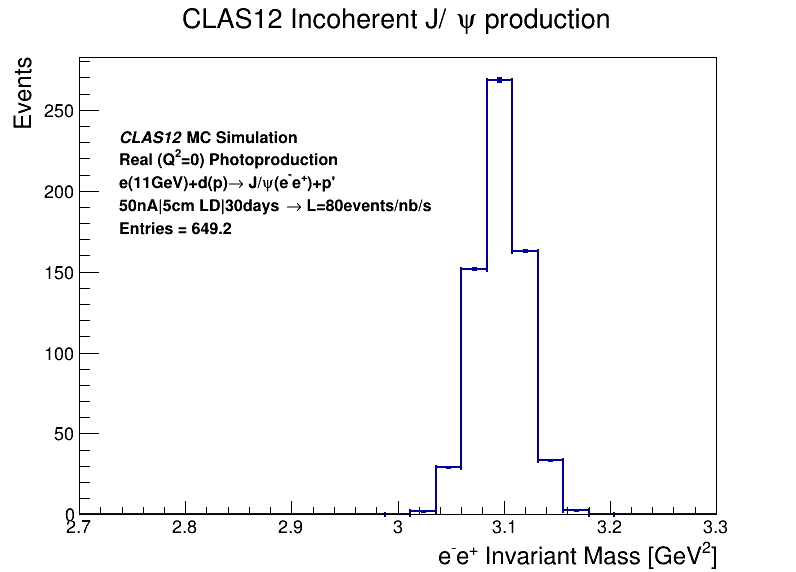

In [132]:
h_incoherent = TH1F("h_incoherent","CLAS12 Incoherent J/#psi production;e^{-}e^{+} Invariant Mass [GeV^{2}];Events",25,2.7,3.3)
t_clas12_incoherent.Draw("m_vm_smear>>h_incoherent","weight*psf*flux*decay_weight*acc_hOut*acc_eMinus*acc_ePlus*{}/{}".format(lumi_clas12,evts_clas12),"hist e1")
c.Draw()
gPad.SetGrid(0,0)
error=np.array([0.0])
integral=h_incoherent.IntegralAndError(0,25,error)
latex.DrawLatexNDC(0.15,0.75,"#it{CLAS12} MC Simulation")
latex.DrawLatexNDC(0.15,0.71,"Real (Q^{2}=0) Photoproduction")
latex.DrawLatexNDC(0.15,0.67,"e(11GeV)+d(p)#rightarrow J/#psi(e^{-}e^{+})+p'")
latex.DrawLatexNDC(0.15,0.63,"50nA|5cm LD|30days #rightarrow L=80events/nb/s")
latex.DrawLatexNDC(0.15,0.59,"Entries = {}".format(np.round(integral,1)))

# CLAS12 (w/ EPA)

In [134]:
f_clas12_coherent = TFile("./data/test_py_quasi_ed_beamE_11.00_evts_5000000_process_photo_coherent_detector_CLAS12_model_PomeronLQCD.root","r")
t_clas12_coherent = f_clas12_coherent.Get("tree")

f_clas12_incoherent = TFile("./data/test_py_quasi_ed_beamE_11.00_evts_5000000_process_photo_incoherent_detector_CLAS12_model_PomeronLQCD.root","r")
t_clas12_incoherent = f_clas12_incoherent.Get("tree")

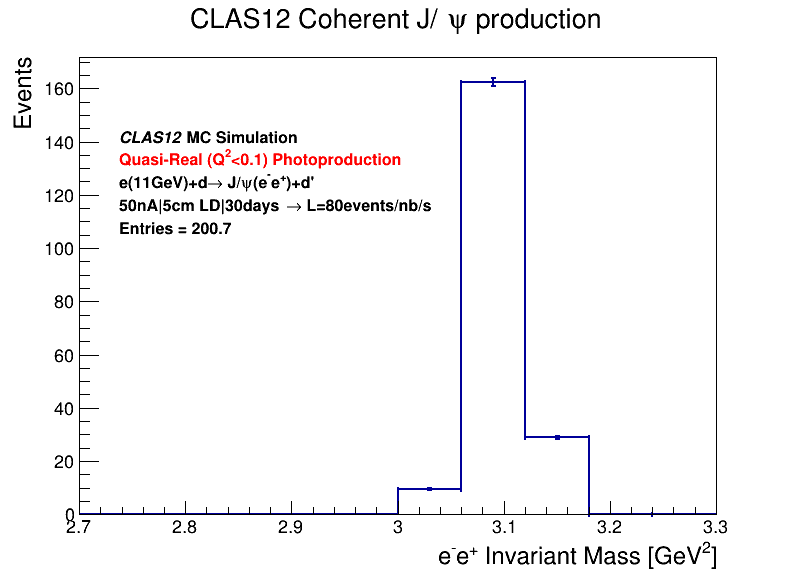

In [135]:
h_coherent = TH1F("h_coherent","CLAS12 Coherent J/#psi production;e^{-}e^{+} Invariant Mass [GeV^{2}];Events",10,2.7,3.3)
t_clas12_coherent.Draw("m_vm_smear>>h_coherent","weight*psf*flux*decay_weight*acc_hOut*acc_eMinus*acc_ePlus*{}/{}".format(lumi_clas12,evts_clas12),"hist e1")
c.Draw()
gPad.SetGrid(0,0)
error=np.array([0.0])
integral=h_coherent.IntegralAndError(0,10,error)
latex.DrawLatexNDC(0.15,0.75,"#it{CLAS12} MC Simulation")
latex.DrawLatexNDC(0.15,0.71,"#color[2]{Quasi-Real (Q^{2}<0.1) Photoproduction}")
latex.DrawLatexNDC(0.15,0.67,"e(11GeV)+d#rightarrow J/#psi(e^{-}e^{+})+d'")
latex.DrawLatexNDC(0.15,0.63,"50nA|5cm LD|30days #rightarrow L=80events/nb/s")
latex.DrawLatexNDC(0.15,0.59,"Entries = {}".format(np.round(integral,1)))

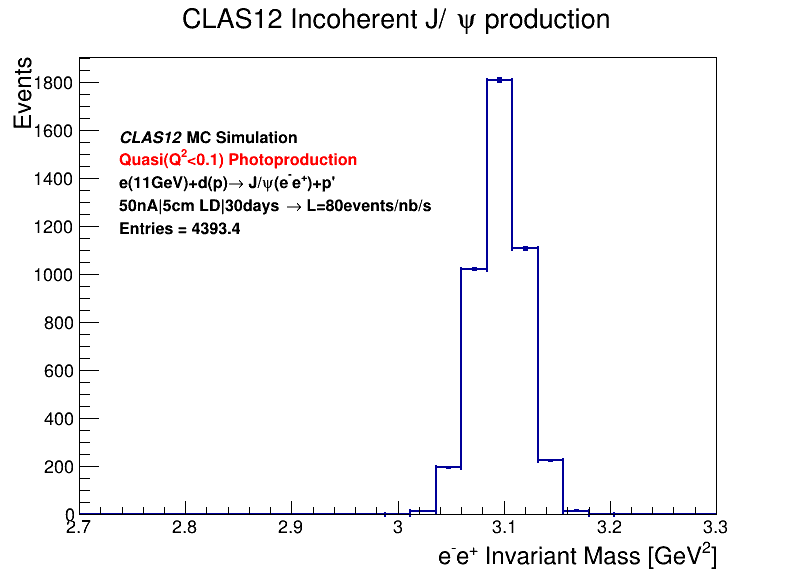

In [136]:
h_incoherent = TH1F("h_incoherent","CLAS12 Incoherent J/#psi production;e^{-}e^{+} Invariant Mass [GeV^{2}];Events",25,2.7,3.3)
t_clas12_incoherent.Draw("m_vm_smear>>h_incoherent","weight*psf*flux*decay_weight*acc_hOut*acc_eMinus*acc_ePlus*{}/{}".format(lumi_clas12,evts_clas12),"hist e1")
c.Draw()
gPad.SetGrid(0,0)
error=np.array([0.0])
integral=h_incoherent.IntegralAndError(0,25,error)
latex.DrawLatexNDC(0.15,0.75,"#it{CLAS12} MC Simulation")
latex.DrawLatexNDC(0.15,0.71,"#color[2]{Quasi(Q^{2}<0.1) Photoproduction}")
latex.DrawLatexNDC(0.15,0.67,"e(11GeV)+d(p)#rightarrow J/#psi(e^{-}e^{+})+p'")
latex.DrawLatexNDC(0.15,0.63,"50nA|5cm LD|30days #rightarrow L=80events/nb/s")
latex.DrawLatexNDC(0.15,0.59,"Entries = {}".format(np.round(integral,1)))

# SoLID

In [7]:
f_solid_photo = TFile("./data/test_py_ed_beamE_8.80_evts_5000000_process_photo_coherent_detector_SoLID_model_PomeronLQCD.root","r")
t_solid_photo = f_solid_photo.Get("tree")

2343.903873682022

Warning in <TFile::Append>: Replacing existing TH1: h (Potential memory leak).


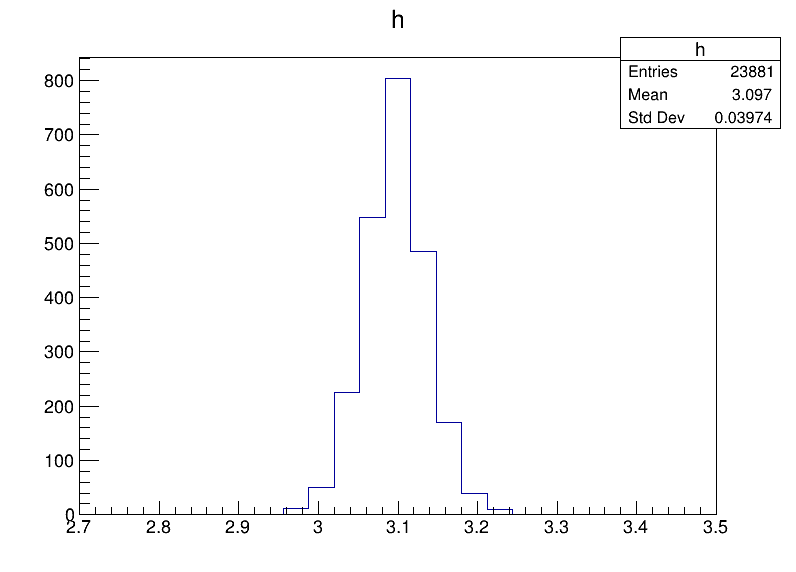

In [16]:
h = TH1F("h","h",25,2.7,3.5)
t_solid_photo.Draw("smear_VM.M()>>h","weight*psf*flux*decay_weight*acc_ePlus*acc_eMinus*acc_hOut*{}/{}".format(25752431250.0,5000000),"hist")
c.Draw()
c.SetLogy(0)
h.Integral()

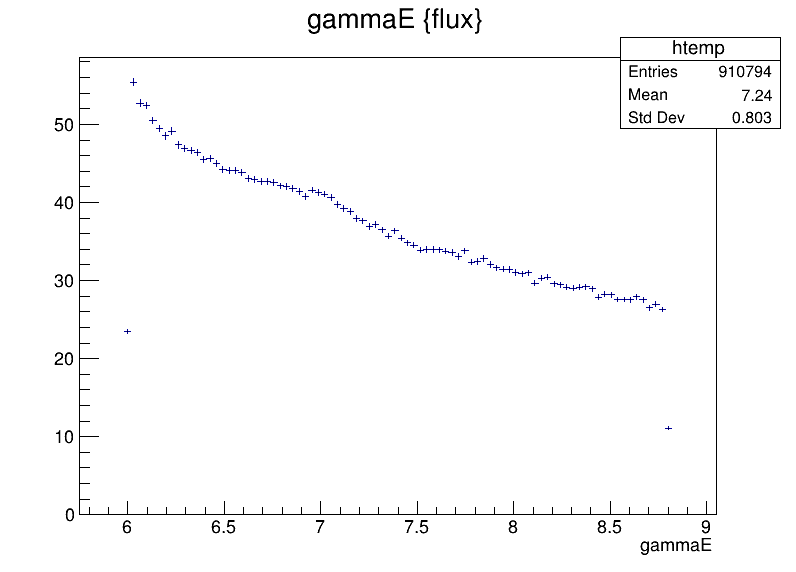

In [18]:
t_solid_photo.Draw("gammaE","flux")
c.Draw()

In [13]:
f_solid_electro = TFile("./data/test_py_ed_beamE_8.50_evts_1000000_process_electro_detector_SoLID_model_PomeronLQCD.root","r")
t_solid_electro = f_solid_electro.Get("tree")

array([1592.68988733])

Warning in <TFile::Append>: Replacing existing TH1: h (Potential memory leak).


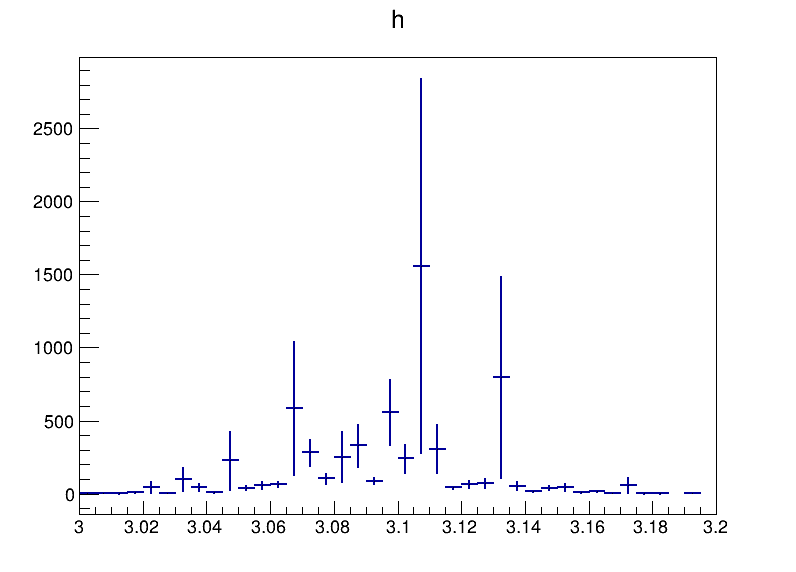

In [26]:
h = TH1F("h","h",40,3,3.2)
t_solid_electro.Draw("m_vm_smear>>h","(gammaE>8.2&&flux<10)*weight*psf*flux*decay_weight*acc_ePlus*acc_eMinus*acc_hOut*{}/{}".format(24207285375.0,1000000))
c.Draw()
c.SetLogy(0)
error=np.array([0.0])
h.IntegralAndError(0,40,error)
error

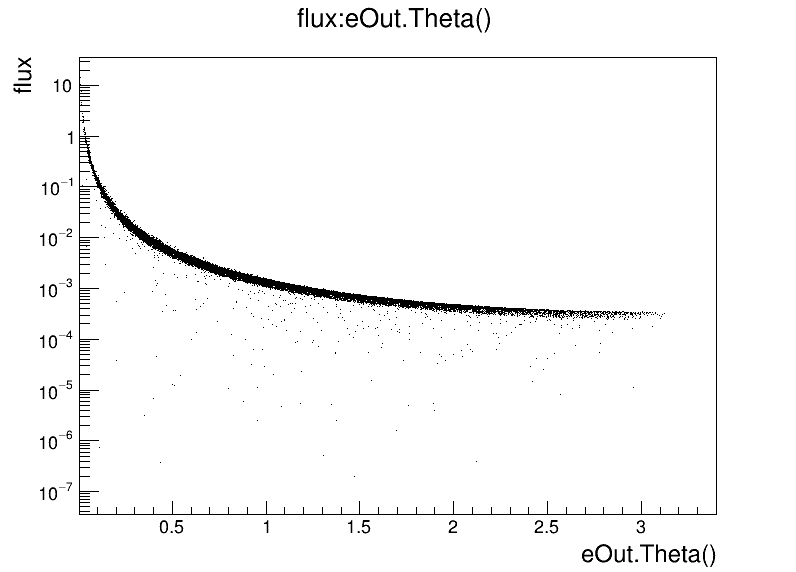

In [16]:
t_solid_electro.Draw("flux:eOut.Theta()")
c.SetLogy(1)
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TFile::Append>: Replacing existing TH1: h (Potential memory leak).


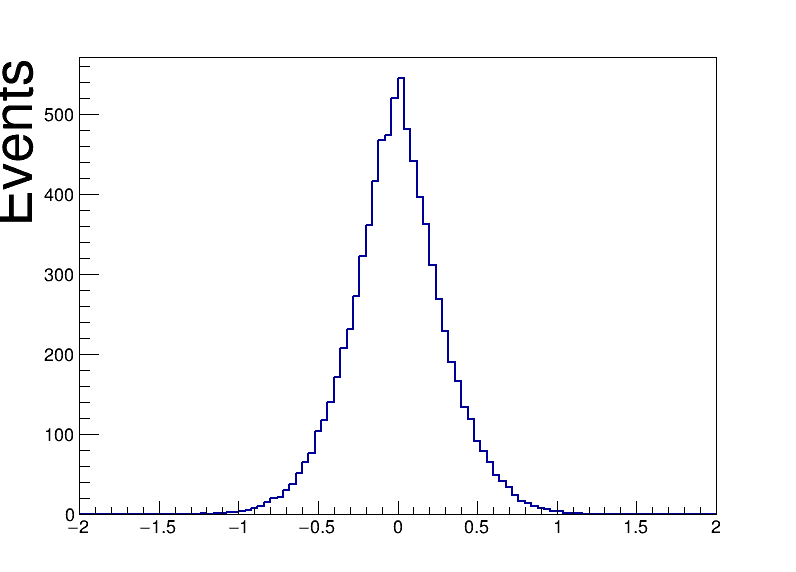

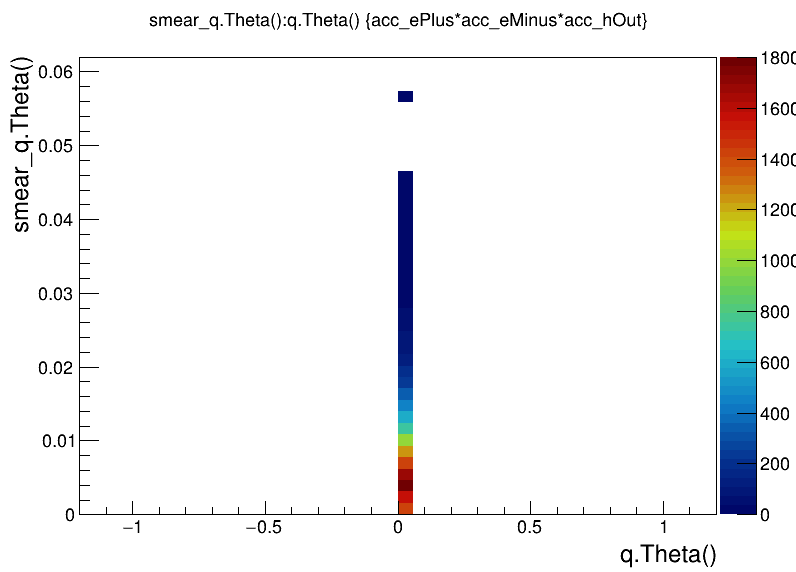

In [13]:
tree.Draw("smear_q.Theta():q.Theta()","acc_ePlus*acc_eMinus*acc_hOut","colz")
c.Draw()

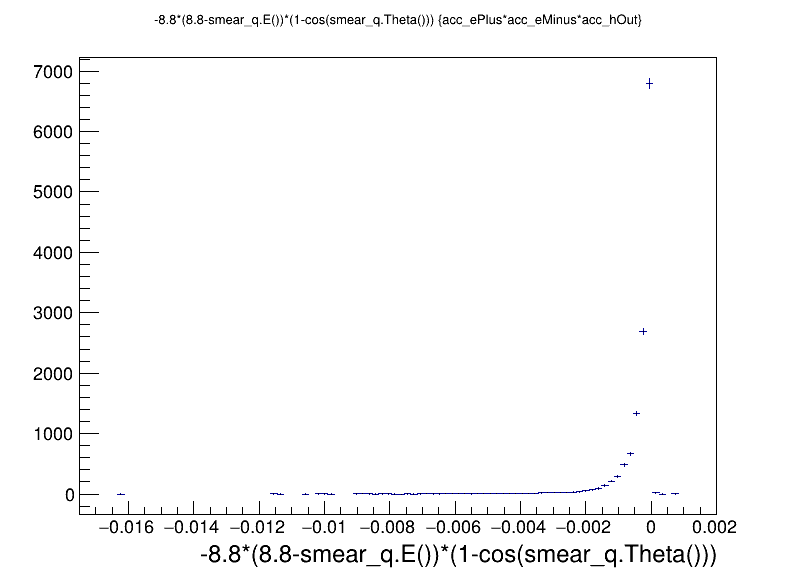

In [16]:
tree.Draw("-8.8*(8.8-smear_q.E())*(1-cos(smear_q.Theta()))","acc_ePlus*acc_eMinus*acc_hOut","colz")
c.Draw()